In [44]:
from hossam import *
from pandas import DataFrame, Series, concat
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from itertools import product
from scipy.spatial import ConvexHull


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 성능 평가 지표 모듈
from sklearn.metrics import *


import sys

sys.path.append("/Users/jinwoo/Machine_Learning")

from hs_eval_utils import (
    hs_get_scores,
    hs_learning_cv,
    hs_get_score_cv,
    feature_importance,
    hs_shap_analysis,
    hs_describe,
    category_describe,
)

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    precision_recall_curve,
)

import shap

In [45]:
origin = load_data("pima_indians_diabetes_preprocessed")
origin.head()

캐글에서 제공하는 pima_indians_diabetes의 전처리 완료 버전(결측치 정제+로그변환) (출처: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1.946,5.004,72,3.584,4.836,3.544,0.487,3.932,1
1,0.693,4.454,66,3.401,4.836,3.318,0.301,3.466,0
2,2.197,5.215,64,3.401,4.836,3.190,0.514,3.497,1
3,0.693,4.500,66,3.178,4.554,3.371,0.154,3.091,0
4,0.000,4.927,40,3.584,5.130,3.786,1.190,3.526,1


In [46]:
df = origin.copy()

# 중요!!! 종속변수를 정수형으로 변환해야 한다.
df["Outcome"] = df["Outcome"].astype("int")

yname = "Outcome"
x = df.drop(columns=[yname])
y = df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=52
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [47]:
%%time

pipe = Pipeline(
    [
        ("VIF_Selector", VIFSelector()),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(random_state=52)),
    ]
)

param_grid = {
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"],
    "model__C": [0.01, 0.1, 1, 10, 100],
    "model__max_iter": [100, 300, 500],
    "model__class_weight": [None, "balanced"],
}

gs = GridSearchCV(
    estimator=pipe, param_grid=param_grid, cv=5, scoring="roc_auc", n_jobs=-1
)

gs.fit(x_train, y_train)

estimator = gs.best_estimator_
estimator

CPU times: user 113 ms, sys: 82.8 ms, total: 196 ms
Wall time: 4.11 s


Pipeline(steps=[('VIF_Selector', VIFSelector()), ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=1, class_weight='balanced',
                                    random_state=52))])

In [48]:
# pipeline에서 단독 학습 모델 객체 추출
model = estimator.named_steps["model"]

# 훈련 데이터에 있는 VIF 선택기와 스케일러 변환 적용
x_vif = estimator.named_steps["VIF_Selector"].transform(x_train)
x_scaled = estimator.named_steps["scaler"].transform(x_vif)

# 훈련 데이터의 스케일링된 특징 행렬을 사용하여 SHAP 마스커 생성
masker = shap.maskers.Independent(x_scaled)

# 선형 설명자 생성
explainer = shap.LinearExplainer(model, masker=masker)

# SHAP 값 계산: shape = [n_samples, n_features]
shap_values = explainer.shap_values(x_scaled)
shap_values

array([[ 0.36637001,  1.19352029, -0.02374752, ...,  0.13558711,
         0.0109997 ,  0.3214378 ],
       [ 0.49955471, -0.66502013,  0.00984162, ...,  1.34818579,
        -0.39504107,  0.25401179],
       [ 0.36637001,  0.19161826, -0.01702969, ..., -0.27607911,
         0.26673056,  0.46305622],
       ...,
       [ 0.0942495 , -0.19673964,  0.01991836, ..., -1.18774282,
        -0.0015263 ,  0.13042584],
       [-0.00905658, -1.44309066,  0.03671293, ..., -1.20308754,
         0.01213369, -0.41599405],
       [ 0.25002199, -0.8945048 ,  0.04343076, ...,  0.2996527 ,
        -0.00381409,  0.2769961 ]])

In [49]:
shap_df = DataFrame(
    shap_values,
    columns=x_vif.columns,
    index=x_vif.index,
)

summary_df = DataFrame(
    {
        "feature": shap_df.columns,
        "mean_abs_shap": shap_df.abs().mean().values,
        "mean_shap": shap_df.mean().values,
        "std_shap": shap_df.std().values,
    }
)

# [셀 3] 방향/변동성/누적 80% 중요변수
summary_df["direction"] = np.where(
    summary_df["mean_shap"] > 0,
    "양(+) 경향",
    np.where(summary_df["mean_shap"] < 0, "음(-) 경향", "혼합/미약"),
)

summary_df["cv"] = summary_df["std_shap"] / (summary_df["mean_abs_shap"] + 1e-9)
summary_df["variability"] = np.where(
    summary_df["cv"] < 1,
    "stable",
    "variable",
)

summary_df = summary_df.sort_values("mean_abs_shap", ascending=False).reset_index(
    drop=True
)

total_importance = summary_df["mean_abs_shap"].sum()
summary_df["importance_ratio"] = summary_df["mean_abs_shap"] / total_importance
summary_df["importance_cumsum"] = summary_df["importance_ratio"].cumsum()

summary_df["is_important"] = np.where(
    summary_df["importance_cumsum"] <= 0.8,
    "core",
    "secondary",
)

summary_df

,feature,mean_abs_shap,mean_shap,std_shap,direction,cv,variability,importance_ratio,importance_cumsum,is_important
0,Glucose,0.918,-0.039,1.131,음(-) 경향,1.232,variable,0.388,0.388,core
1,BMI,0.572,0.053,0.708,양(+) 경향,1.236,variable,0.242,0.630,core
2,Pregnancies,0.301,-0.048,0.356,음(-) 경향,1.182,variable,0.127,0.757,core
3,Age,0.277,-0.027,0.318,음(-) 경향,1.150,variable,0.117,0.874,secondary
4,DiabetesPedigreeFunction,0.254,0.014,0.318,양(+) 경향,1.249,variable,0.108,0.982,secondary
5,BloodPressure,0.031,-0.005,0.040,음(-) 경향,1.298,variable,0.013,0.995,secondary
6,Insulin,0.009,-0.001,0.016,음(-) 경향,1.657,variable,0.004,0.999,secondary
7,SkinThickness,0.003,-0.000,0.004,음(-) 경향,1.409,variable,0.001,1.000,secondary


In [50]:
x = DataFrame(x_scaled, columns=x_vif.columns, index=x_vif.index)
x

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
754,1.165,1.091,0.464,0.452,0.007,0.117,-0.010,1.096
558,1.540,-0.554,-0.373,1.144,0.007,1.832,-1.289,0.884
584,1.165,0.205,0.297,-0.432,3.161,-0.465,0.795,1.541
78,-1.696,0.429,-0.038,0.149,0.007,1.507,-0.668,-0.580
193,1.540,0.552,-0.038,0.149,0.007,2.435,0.451,0.734
...,...,...,...,...,...,...,...,...
503,1.012,-0.927,-0.707,-0.307,-0.910,0.249,0.948,0.810
86,1.740,-0.436,-0.038,2.080,0.007,0.705,-1.056,1.096
151,0.400,-0.139,-0.624,0.149,0.007,-1.754,-0.050,0.495
525,0.109,-1.242,-1.042,-1.306,0.007,-1.776,-0.007,-1.224


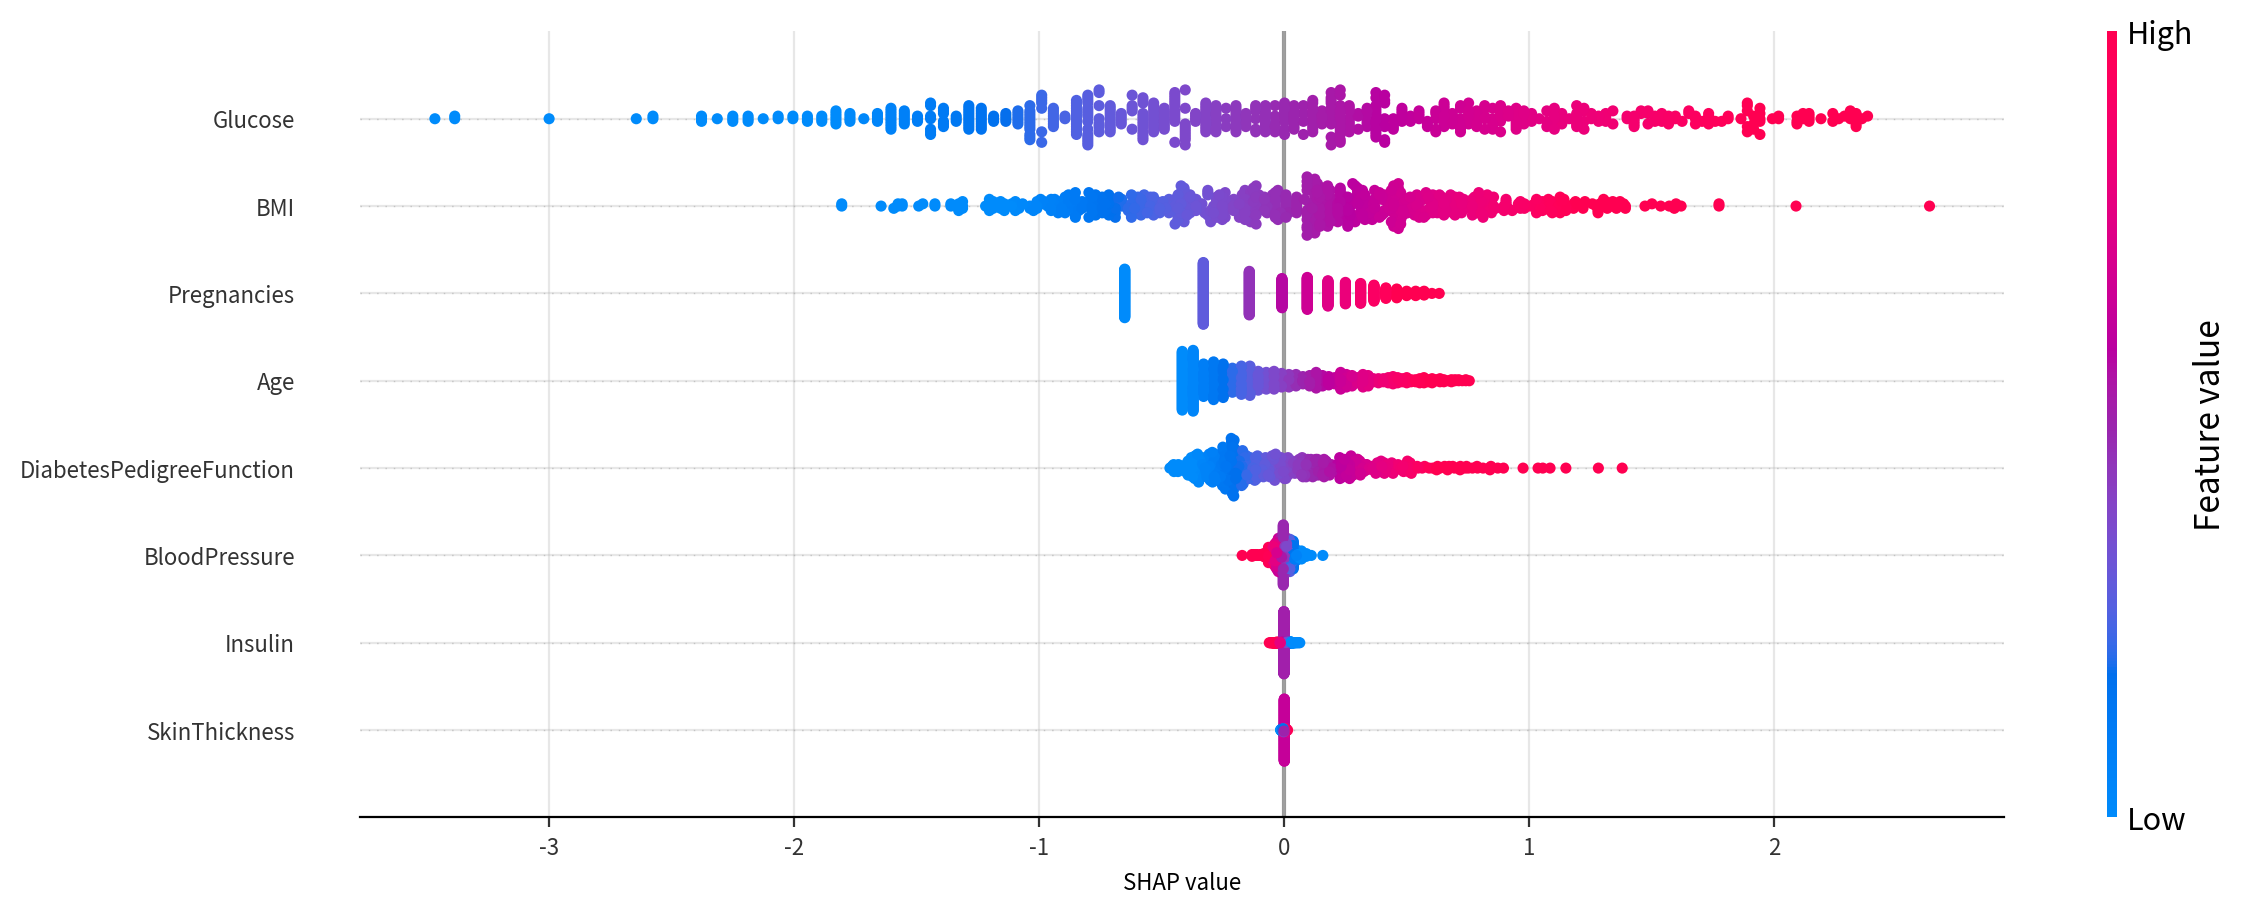

In [51]:
width = 1600
my_dpi = 200

shap.summary_plot(shap_values, x, show=False)

fig = plt.gcf()
fig.set_size_inches(width / 100, len(summary_df) * 60 / 100)
fig.set_dpi(my_dpi)
ax = fig.get_axes()[0]

ax.grid(True, alpha=0.3)

plt.xlabel("SHAP value", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()
plt.close()

In [52]:
def hs_shap_analysis(
    model,
    x: DataFrame,
    plot: bool = True,
    width: int = 1600,
):

    # =====================================================
    # [NEW] SHAP 유형 판별
    # =====================================================
    # Pipeline 라인 객체와 그렇지 않은 경우도 처리
    if isinstance(model, Pipeline):
        estimator = model.named_steps["model"]
        is_pipeline = True
    else:
        estimator = model
        is_pipeline = False

    # 선형 계열인지 판별
    is_linear_model = isinstance(
        estimator,
        (LinearRegression, Ridge, Lasso, SGDRegressor, LogisticRegression),
    )

    # 전달된 독립변수 복사
    x_df = x.copy()
    columns = x.columns.tolist()
    indexs = x.index.tolist()

    # =====================================================
    # SHAP 분석
    # =====================================================
    # 1. SHAP Explainer
    if is_linear_model:

        # pipeline인 경우 전처리 step 적용
        if is_pipeline:
            for name, step in list(model.named_steps.items()):
                if name == "model":
                    continue
                x_df = step.transform(x_df)  # type: ignore

        masker = shap.maskers.Independent(x_df)
        explainer = shap.LinearExplainer(estimator, masker=masker)

    else:
        explainer = shap.TreeExplainer(estimator)

    # 2. SHAP 값 계산
    shap_values = explainer.shap_values(x_df)

    # 3. DataFrame 변환
    shap_df = DataFrame(
        shap_values,
        columns=columns,
        index=indexs,
    )

    # =====================================================
    # 요약 통계
    # =====================================================
    summary_df = DataFrame(
        {
            "feature": shap_df.columns,
            "mean_abs_shap": shap_df.abs().mean().values,
            "mean_shap": shap_df.mean().values,
            "std_shap": shap_df.std().values,
        }
    )

    # 5. 영향 방향
    summary_df["direction"] = np.where(
        summary_df["mean_shap"] > 0,
        "양(+) 경향",
        np.where(summary_df["mean_shap"] < 0, "음(-) 경향", "혼합/미약"),
    )

    # 6. 변동성 지표
    summary_df["cv"] = summary_df["std_shap"] / (summary_df["mean_abs_shap"] + 1e-9)

    summary_df["variability"] = np.where(
        summary_df["cv"] < 1,
        "stable",
        "variable",
    )

    # 7. 중요도 기준 정렬
    summary_df = summary_df.sort_values("mean_abs_shap", ascending=False).reset_index(
        drop=True
    )

    # 8. 중요 변수 표시 (누적 80%)
    total_importance = summary_df["mean_abs_shap"].sum()

    summary_df["importance_ratio"] = summary_df["mean_abs_shap"] / total_importance

    summary_df["importance_cumsum"] = summary_df["importance_ratio"].cumsum()

    summary_df["is_important"] = np.where(
        summary_df["importance_cumsum"] <= 0.80,
        "core",
        "secondary",
    )

    # =====================================================
    # 시각화
    # =====================================================
    if plot:

        shap.summary_plot(shap_values, x_df, show=False)

        fig = plt.gcf()
        fig.set_size_inches(width / my_dpi, len(summary_df) * 70 / my_dpi)

        ax = fig.get_axes()[0]
        ax.set_title("SHAP Summary Plot", fontsize=10, pad=10)

        plt.xlabel("SHAP value", fontsize=8)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
        plt.close()

    return summary_df, shap_values

In [53]:
summary_df, shap_values = hs_shap_analysis(estimator, x_train)

display(summary_df)
display(shap_values[:5])

NameError: name 'LinearRegression' is not defined

In [ ]:
hs_shap_dependence_analysis(
    summary_df,
    shap_values,
    DataFrame(x_scaled, columns=x.columns)
)
